[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/119_ssm/119_ssm.ipynb)

# State Space Models

Recientemente se ha publicado una nueva arquitectura de red neuronal que promete destronar a los Transformers. Este modelo se conoce como [Mamba](https://arxiv.org/pdf/2312.00752.pdf), y con este post iniciamos una serie de posts en los que aprenderemos sobre Mamba y sus componentes comenzando por los `State Space Models`. Estos modelos son una forma de representar sistemas dinámicos, y son muy utilizados en el campo de la ingeniería y la física. Son útiles a la hora de modelar de manera eficiente secuencias de datos largas y pueden usarse también para diseñar redes neuronales. 

## Fundamentos matemáticos

Una forma general de representación de espacios de estado de un sistema lineal con $p$ entradas, $q$ salidas y $n$ variables de estado se escribe de la siguiente forma:

$$
x'(t) = A x(t) + B u(t)
$$
$$
y(t) = C x(t) + D u(t)
$$

donde $x(t)$ es el vector de estados, con $n$ variables de estado, $u(t)$ es el vector de entrada, con $p$ valores de entrada, $y(t)$ es el vector de salida, con $q$ valores de salida y $A$ es la matriz de estado, $B$ es la matriz de entrada, $C$ es la matriz de salida y $D$ es la matriz de transmisión directa, en todos los casos parámetros que aprenderemos durante el entrenamiento del modelo (y que podrían depender de $t$ a no ser que consideremos un sistema invariante en el tiempo). $x'(t)$ es la derivada temporal de $x(t)$, por lo que el sistema de ecuaciones es un sistema de ecuaciones diferenciales lineales.

Para entenderlo con un ejemplo, podríamos considerar que $u(t)$ es una serie temporal que determina la evolución de la temperatura y humedad en una ciudad, con dos variables. Entonces, $x(t)$ podría representar características como la presión atmosférica, la velocidad del viento, la temperatura del suelo, época del año, etc, en un número determinado de estados que no tiene porque ser igual al número de variables de entrada. Estos estados explicarían la evolución de la temperatura y humedad en la ciudad, y podrían usarse para predecir la probabilidad de lluvia, $y(t)$, una sola variable. Podemos empezar a intuir porqué estos modelos son ideales para su uso en redes neuronales, ya que permiten modelar secuencias de datos de manera eficiente. Podríamos usarlos para clasificar imágenes, donde $u(t)$ podría ser la secuencia de píxeles o patches, $y(t)$ la distribución de probabilidad sobre las clases y $x(t)$ las características visuales útiles para la clasificación (que normalmente calcularía una red convolucional apartir de sus filtros, que en este caso serían equivalente a las matrices del sistema). Otras aplicaciones incluyen campos como la economía, ingeniería, física, biología, etc.

In [1]:
import torch 

def random_SSM(p, q, n):
	A = torch.rand((n, n))
	B = torch.rand((n, p))
	C = torch.rand((q, n))
	return A, B, C

## Representación Discreta

El primer paso para el uso de SSMs en redes neuronales es la discretización del sistema, ya que no trabajaremos con secuencias contínuas sino series temporals, píxeles o patches en imágenes, tokens en secuencias de texto, etc. Para ello, podemos usar el método [bilineal](https://es.wikipedia.org/wiki/Transformaci%C3%B3n_bilineal) que permite aproximar las matrices en sus variantes discretas y representar el sistema de ecuaciones de la siguiente forma:

$$
x_{k+1} = \overline{A} x_k + \overline{B} u_k
$$
$$
y_k = \overline{C} x_k
$$

donde ignoramos el término $D u(t)$ ya que podemos interpretarlo como una $skip connection$ que siempre podemos añadir más adelante. En esta representación, $u_k = u(k \Delta)$ donde $\Delta$ es el intervalo de tiempo entre muestras, el *step*.

In [7]:
def discretize(A, B, C, step):
	I = torch.eye(A.shape[0])
	BL = torch.inverse(I - (step / 2.0) * A)
	Ab = BL @ (I + (step / 2.0) * A)
	Bb = (step * BL) @ B
	return Ab, Bb, C

Esta forumalción es posible que te recuerde a la que introdujimos en el post sobre [redes recurrente](https://juansensio.com/blog/034_rnn_intro).

![rnn](https://miro.medium.com/max/2544/1*aIT6tmnk3qHpStkOX3gGcQ.png)

Estas redes procesan cada *input* de manera independiente, pero mantienen una memoria interna que les permite recordar información de pasos anteriores. 

$$ \mathbf{h}_t =  f(\mathbf{W}_x \mathbf{x}_t + \mathbf{W}_h \mathbf{h}_{t-1}) $$
$$ \mathbf{y}_t = \mathbf{W}_y \mathbf{h}_t$$

In [69]:
def run_SSM(A, B, C, u):
    b, L, p = u.shape
    q, n = C.shape
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)
    y = torch.zeros((b, L, q))
    x = torch.zeros((b, L, n))
    for i in range(L):
        x[:,i] = x[:,i - 1] @ Ab.T if i > 0 else 0 + u[:,i] @ Bb.T
        y[:,i] = x[:,i] @ Cb.T
    return x, y

In [70]:
def discretize(A, B, C, step):
	I = torch.eye(A.shape[0])
	BL = torch.inverse(I - (step / 2.0) * A)
	Ab = BL @ (I + (step / 2.0) * A)
	Bb = (step * BL) @ B
	return Ab, Bb, C

In [72]:
p, q, n = 2, 3, 4
B, L = 5, 10

ssm = random_SSM(p, q, n)
u = torch.rand((B, L, p))
x, y = run_SSM(*ssm, u)

x.shape, y.shape

(torch.Size([5, 10, 4]), torch.Size([5, 10, 3]))

Este formulación es muy útil para hacer inferencia, ya que es una formulación autoregresiva en la que en cada instante solo necesitamos el estado anterior para calcular el siguiente (a diferencia del transformer en la que necesitamos todo el contexto cada vez que queremos generar una nueva salida). Sin embargo, ya sabemos que no es la formulación más eficiente para el entrenamiento. Para ello, nos inspiramos en el funcionamiento de las redes convolucionales.

## Entrenando SSMs

Para entrenar SSMs de manera eficiente, vamos a formular el problema paso a paso:

$$ x_0 = \overline{B} u_0 \rightarrow y_0 = \overline{CB} x_0 $$
$$ x_1 = \overline{AB} u_0 + \overline{B} u_1 \rightarrow y_1 = \overline{CAB} u_0 + \overline{CB} u_1 $$
$$ x_2 = \overline{A}^2 \overline{B} u_0 + \overline{AB} u_1 + \overline{B} u_2 \rightarrow y_2 = \overline{CA}^2 \overline{B} u_0 + \overline{CAB} u_1 + \overline{CB} u_2 $$
$$ ... $$

Esto se puede vectorizar de la siguiente forma:

$$ y_k = \overline{CA}^k \overline{B} u_0 + \overline{CA}^{k-1} \overline{B} u_1 + ... + \overline{CAB} u_{k-1} + \overline{CB} u_{k} $$

de forma que podemos calcular la salida en el paso $k$ de manera eficiente con la siguiente convolución:

$$ y = \overline{K} * u $$

donde $\overline{K} = (\overline{CB},\overline{CAB}, ...,  \overline{CA}^{L-1} \overline{B}) $ es la matriz de convolución que se calcula de la siguiente forma:

In [74]:
def K_conv(Ab, Bb, Cb, L):
    return torch.tensor(
        [(Cb @ torch.matrix_power(Ab, l) @ Bb) for l in range(L)]
    )

import torchaudio 

def causal_convolution(u, K):
     # no está en torch ?
	return torchaudio.functional.convolve(u, K, mode="full")[: u.shape[0]] 

def test_cnn_is_rnn(p, q, n, B, L):
    step=1.0 / L
    ssm = random_SSM(p, q, n)
    u = torch.rand((B, L, 1))
    # RNN
    rec = run_SSM(*ssm, u)
    # CNN
    ssmb = discretize(*ssm, step=step)
    K = K_conv(*ssmb, L)
    conv = causal_convolution(u, K)
    # Check
    assert torch.allclose(rec[1].view(-1), conv.view(-1))
    # return rec[1], conv, K

ModuleNotFoundError: No module named 'torchaudio'

In [61]:
test_cnn_is_rnn() # no da bien

AssertionError: 

Con todas estas piezas en su lugar, podemos definir ahora una capa SSM para nuestra red neuronal.

In [16]:
import numpy as np 

class SSMLayer(torch.nn.Module):
	def __init__(self, p, q, n, dt_min=0.001, dt_max=0.1, l_max=16, p_drop=0):
		super().__init__()
		self.A = torch.nn.Parameter(torch.rand((n, n)))
		self.B = torch.nn.Parameter(torch.rand((n, p)))
		self.C = torch.nn.Parameter(torch.rand((q, n)))
		self.D = torch.nn.Parameter(torch.ones((p,)))
		self.log_step = torch.nn.Parameter(torch.rand(1,)*(np.log(dt_max) - np.log(dt_min)) + np.log(dt_min))
		step = torch.exp(self.log_step)
		self.ssm = discretize(self.A, self.B, self.C, step)
		self.K = K_conv(*self.ssm, l_max)
		self.norm = torch.nn.LayerNorm(n)
		self.drop = torch.nn.Dropout(p_drop)

	def forward(self, x, train=False):
		skip = x 
		x = self.norm(x)
		x = causal_convolution(x, self.K) + self.D * x
		x = torch.nn.functional.gelu(x)
		return self.drop(x)	+ skip		

Podemos usar este modelo para, por ejemplo, clasificar imágenes del dataset MNIST

In [1]:
import lightning as L
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [11]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float().view(1, 28, 28), torch.tensor(self.y[ix]).long()

class MNISTDataModule(L.LightningDataModule):

	def __init__(self, batch_size: int = 64):
		super().__init__()
		self.batch_size = batch_size

	def setup(self, stage=None):
		mnist = fetch_openml('mnist_784', version=1)
		X, y = mnist["data"].values.astype(np.float32), mnist["target"].values.astype(int)
		X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000], y[60000:]
		self.train_ds = Dataset(X_train, y_train)
		self.val_ds = Dataset(X_test, y_test)

	def train_dataloader(self):
		return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

	def val_dataloader(self):
		return DataLoader(self.val_ds, batch_size=self.batch_size)

In [12]:
dm = MNISTDataModule()
dm.setup()

imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

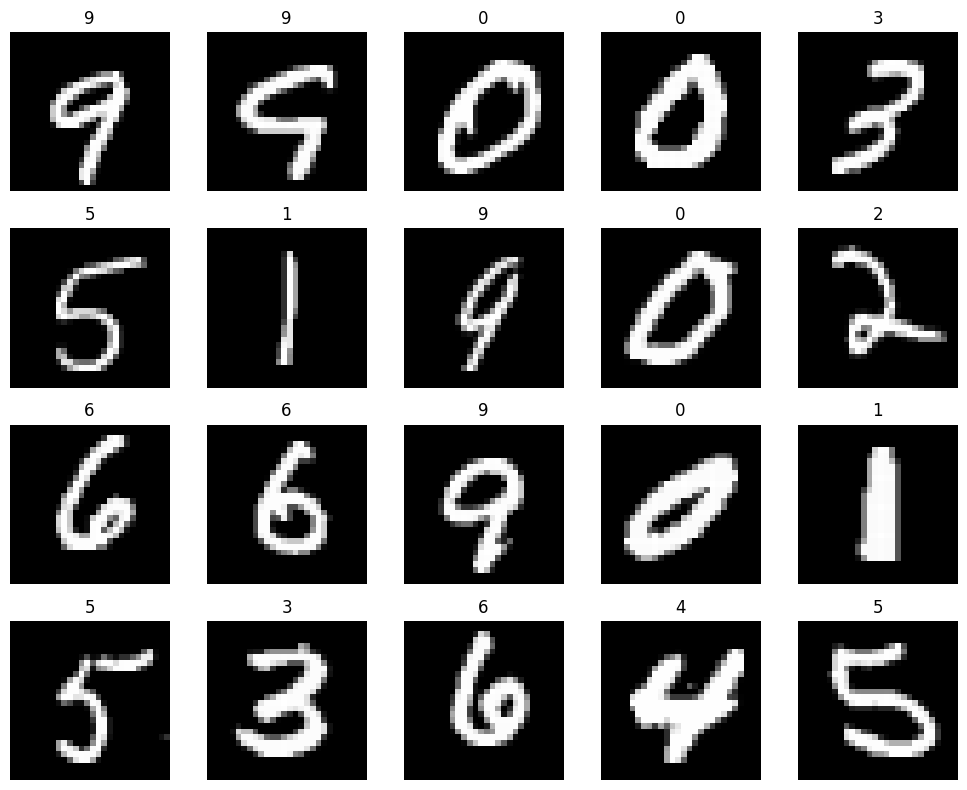

In [13]:
r, c = 4, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

In [14]:
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x
    
class SSMModel(torch.nn.Module):

    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=100, n_heads=3, n_layers=3, n_classes=10):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        
        self.ssm_layers = torch.nn.Sequential(*[SSMLayer(1, 1, 4) for _ in range(n_layers)])
        
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        e = self.patch_embed(x)
        B, L, E = e.size()
        
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        e = torch.cat((cls_token, e), dim=1)  # (B, 1 + N, E)
        e = e + self.pos_embed  # (B, 1 + N, E)
        
        z = self.ssm_layers(e)
        
        cls_token_final = z[:, 0]  
        y = self.fc(cls_token_final)

        return y

In [17]:
model = SSMModel()
out = model(imgs)
out.shape

NameError: name 'discretize' is not defined

In [ ]:
class Model(L.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = SSMModel()

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [ ]:
model = Model()
trainer = L.Trainer(max_epochs=5, gpus=1, logger=None)
trainer.fit(model, dm)

In [ ]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

## Recursos

Posts:

- State space models: https://es.wikipedia.org/wiki/Espacio_de_estados
- Mamba: https://jameschen.io/jekyll/update/2024/02/12/mamba.html
- The Annotated S4: https://srush.github.io/annotated-s4/
- Mamba The Easy Way: https://jackcook.com/2024/02/23/mamba.html

Papers:

- S4: https://arxiv.org/abs/2111.00396
- Mamba: https://arxiv.org/abs/2312.00752
- MoE-Mamba: https://arxiv.org/abs/2401.04081 
- Vision Mamba: https://arxiv.org/abs/2401.09417
- MambaByte: https://arxiv.org/abs/2401.13660 

Código:

- Mamba-tiny: https://github.com/PeaBrane/mamba-tiny 
